# Basic Multi-agent Collaboration

![](./img/simple_multi_agent_diagram.png)

- Set up
- Create agent from llm, system_message and tools(with prompt nested)
- Define tools
- Define Agent state
- Define agent nodes
- Define tool node
- Define Edge logic
- Define graph
- Invoke

# Set up

In [1]:
#!pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core

In [1]:
import os
from getpass import getpass

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass(f"Pass in {var}")

_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")

Pass in OPENAI_API_KEY ········
Pass in TAVILY_API_KEY ········
Pass in LANGCHAIN_API_KEY ········


In [2]:
# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

# Create agent

In [3]:
from langchain_core.prompts.chat import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.utils.function_calling import convert_to_openai_function

def create_agent(llm, tools, system_message: str):
    """Create an agent"""
    functions = [convert_to_openai_function(tool) for tool in tools]
    prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            "You are a helpful AI assistant, collaborating with other assistants."
            " Use the provided tools to progress towards answering the question."
            " If you are unable to fully answer, that's OK, another assistant with different tools "
            " will help where you left off. Execute what you can to make progress."
            " Please note, the answer is out there, use research tool as much as you can until you get to the answer"
            " If you or any of the other assistants have the final answer or deliverable,"
            " prefix your response with FINAL ANSWER so the team knows to stop."
            " You have access to the following tools: {tool_names}.\n{system_message}",
        ),
        MessagesPlaceholder(variable_name="messages")
    ])
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))

    return prompt | llm.bind_functions(functions)
    
    

# Define tools

In [4]:
from langchain_core.tools import tool
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart"]
):
    """
    Use this to execute python code. If you want to see the output of a value, you
    should print it out with `print(....)`. This is visible to the user
    """
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"

    return f"Succesfully executed:\n```python\n{code}\n```\nStdout: {result}"
        
    

# Define state

In [5]:
from typing import Annotated, Sequence, TypedDict
import operator
from langchain_core.messages.base import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str
    

# Define agent nodes

In [6]:
import functools
from langchain_core.messages import FunctionMessage, HumanMessage
from langchain_openai import ChatOpenAI

def agent_node(state, agent, name):

    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, FunctionMessage):
        pass
    else:
        result = HumanMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        "sender": name
    }

llm = ChatOpenAI(model="gpt-4-1106-preview")

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart generator to use."
)
research_node = functools.partial(agent_node, agent=research_agent, name="researcher")

# Chart generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user."
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")


# Define tool node

We now define a node to run the tools

In [7]:
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation
import json

tools = [tavily_tool, python_repl]
tool_executor = ToolExecutor(tools)

def tool_node(state):
    """This runs tools in the graph
    It takes in an agent action and calls that tool and returns the result
    """
    messages = state["messages"]
    last_message = messages[-1]
    tool_input = json.loads(
        last_message.additional_kwargs["function_call"]["arguments"]
    )

    # We can pass single-arg inputs by value
    if len(tool_input) == 1 and "__arg1" in tool_input:
        tool_input = next(iter(tool_input.values()))

    tool_name = last_message.additional_kwargs["function_call"]["name"]
    action = ToolInvocation(tool=tool_name, tool_input=tool_input)

    # Invoke the tool executor
    response = tool_executor.invoke(action)
    # We use the response to create a FunctionMessage 
    function_message = FunctionMessage(
        content=f"{tool_name} response: {str(response)}", name=action.tool
    )
    return {"messages": [function_message]}

# Define Edge Logic

In [8]:
# Either agent can decide to end
def router(state):
    messages = state["messages"]
    last_message = messages[-1]

    if "function_call" in last_message.additional_kwargs:
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        return "end"
    return "continue"

# Define Graph

In [9]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(AgentState)

# Create the nodes
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)


workflow.add_conditional_edges(
    "researcher",
    router,
    {
        "continue": "chart_generator",
        "call_tool": "call_tool",
        "end": END,
    }
)

workflow.add_conditional_edges(
    "chart_generator",
    router,
    {
        "continue": "researcher",
        "call_tool": "call_tool",
        "end": END,
    }
)

workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
        "researcher": "researcher",
        "chart_generator": "chart_generator",
    }
)

workflow.set_entry_point("researcher")
graph = workflow.compile()

# Invoke

{'researcher': {'messages': [HumanMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"UK GDP over the past 5 years"}', 'name': 'tavily_search_results_json'}}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 244, 'total_tokens': 269}, 'model_name': 'gpt-4-1106-preview', 'system_fingerprint': 'fp_94f711dcf6', 'finish_reason': 'function_call', 'logprobs': None}, name='researcher', id='run-a22c63ea-eb2d-459f-b974-7a943c481a8f-0', invalid_tool_calls=[], tool_calls=[])], 'sender': 'researcher'}}
-----------------------------------
{'call_tool': {'messages': [FunctionMessage(content='tavily_search_results_json response: [{\'url\': \'https://www.macrotrends.net/global-metrics/countries/GBR/united-kingdom/gdp-growth-rate\', \'content\': \'U.K. gdp growth rate for 2021 was 7.60%, a 18.63% increase from 2020. U.K. gdp growth rate for 2020 was -11.03%, a 12.64% decline from 2019. U.K. gdp growth rate for 2019 was 1.60%, a 0.1% decline from 

Python REPL can execute arbitrary code. Use with caution.


{'chart_generator': {'messages': [HumanMessage(content='', additional_kwargs={'function_call': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# Years and GDP values\\nyears = [2017, 2018, 2019, 2020, 2021]\\ngdp_values = [2.68564, 2.88185, 2.85706, 2.70461, 3.12248]  # Trillions of USD\\n\\n# Create a line graph\\nplt.figure(figsize=(10, 5))\\nplt.plot(years, gdp_values, marker=\'o\')\\n\\n# Title and labels\\nplt.title(\'UK GDP Over the Past 5 Years\')\\nplt.xlabel(\'Year\')\\nplt.ylabel(\'GDP (Trillions of USD)\')\\n\\n# Grid and show the plot\\nplt.grid(True)\\nplt.show()"}', 'name': 'python_repl'}}, response_metadata={'token_usage': {'completion_tokens': 180, 'prompt_tokens': 6932, 'total_tokens': 7112}, 'model_name': 'gpt-4-1106-preview', 'system_fingerprint': 'fp_fb84c680ea', 'finish_reason': 'function_call', 'logprobs': None}, name='chart_generator', id='run-6b8ae520-308a-447c-9f30-cb33bd459d49-0', invalid_tool_calls=[], tool_calls=[])], 'sender': 'chart_generator'

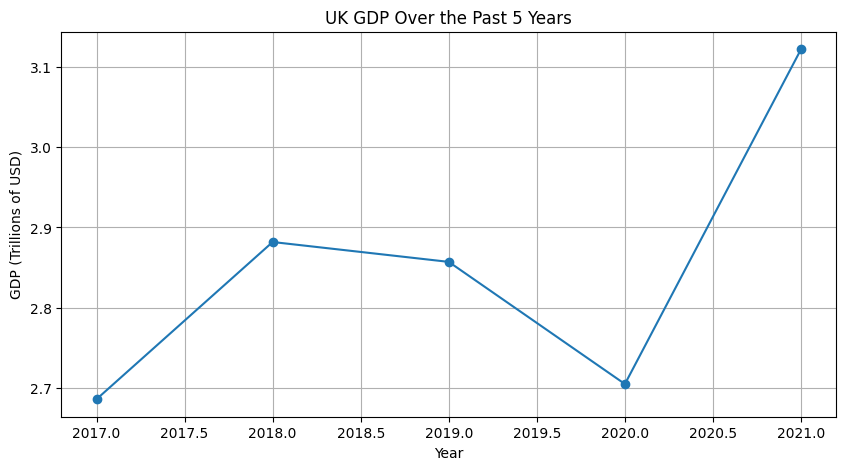

{'call_tool': {'messages': [FunctionMessage(content="python_repl response: Succesfully executed:\n```python\nimport matplotlib.pyplot as plt\n\n# Years and GDP values\nyears = [2017, 2018, 2019, 2020, 2021]\ngdp_values = [2.68564, 2.88185, 2.85706, 2.70461, 3.12248]  # Trillions of USD\n\n# Create a line graph\nplt.figure(figsize=(10, 5))\nplt.plot(years, gdp_values, marker='o')\n\n# Title and labels\nplt.title('UK GDP Over the Past 5 Years')\nplt.xlabel('Year')\nplt.ylabel('GDP (Trillions of USD)')\n\n# Grid and show the plot\nplt.grid(True)\nplt.show()\n```\nStdout: ", name='python_repl')]}}
-----------------------------------
{'chart_generator': {'messages': [HumanMessage(content="Here is the line graph representing the UK's GDP over the past five years:\n\n![UK GDP Over the Past 5 Years](sandbox:/chart)", response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 7115, 'total_tokens': 7146}, 'model_name': 'gpt-4-1106-preview', 'system_fingerprint': 'fp_fb84c680ea'

In [10]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the UK's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ]
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150}
):
    print(s)
    print("-----------------------------------")